<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/Latihan_Neural_Network_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopml

In [11]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import pandas as pd

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.feature_importance import mean_score_decrease
from jcopml.plot import plot_missing_value, plot_confusion_matrix, plot_correlation_matrix

device = torch.device("Cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
datas = pd.read_csv("/content/diabetes.csv")
datas.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [19]:
datas.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
plot_missing_value(datas, return_df=True)

# **#DATASET SPLITTING**

In [15]:
datas.drop(columns="Insulin", inplace=True)

In [37]:
X = datas.drop(columns='Outcome')
y = datas.Outcome.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

# **#PREPROCESSING DATA**

In [38]:
preprocessing = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])
X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)
X_train

array([[1.00e+00, 9.00e+01, 6.20e+01, ..., 2.72e+01, 5.80e-01, 2.40e+01],
       [5.00e+00, 1.26e+02, 7.80e+01, ..., 2.96e+01, 4.39e-01, 4.00e+01],
       [2.00e+00, 1.05e+02, 5.80e+01, ..., 3.49e+01, 2.25e-01, 2.50e+01],
       ...,
       [1.00e+00, 9.70e+01, 7.00e+01, ..., 3.81e+01, 2.18e-01, 3.00e+01],
       [1.00e+01, 1.11e+02, 7.00e+01, ..., 2.75e+01, 1.41e-01, 4.00e+01],
       [4.00e+00, 1.44e+02, 5.80e+01, ..., 2.95e+01, 2.87e-01, 3.70e+01]])

# **#1 DATASET & DATALOADER**

In [39]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [40]:
train_dataset = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
testloader = DataLoader(test_dataset, batch_size=64)

# **#2 Training Preparation -> MCO**

In [41]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.LogSoftmax(1)
)

criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# **#3 Training Loop**

In [42]:
epochs = 1000
train_cost, test_cost = [], []

for i in range(epochs):
  model.train()
  cost = 0
  for feature, target in trainloader:
    output = model(feature) #Feedforward
    loss = criterion(output, target) 
    loss.backward() #back propagation
    optimizer.step() #optimizer

    optimizer.zero_grad()
    cost += loss.item() * feature.shape[0]
  train_cost.append(cost/len(train_dataset))

  with torch.no_grad():
    model.eval()
    cost = 0
    for feature, target in testloader:
      output = model(feature) #Feedforward
      loss = criterion(output, target) 
      cost += loss.item()*feature.shape[0]
    test_cost.append(cost/len(test_dataset))

  print(f"\rEpoch {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}", end=' ')

Epoch 1000/1000 | train_cost: 0.4120 | test_cost: 0.5320 

In [43]:
import matplotlib.pyplot as plt

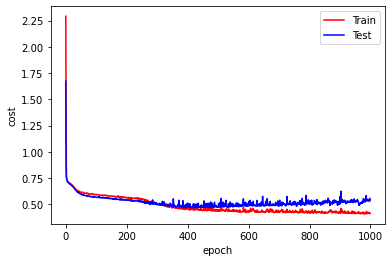

In [44]:
plt.plot(train_cost, 'r-', label='Train')
plt.plot(test_cost, 'b-', label='Test')
plt.xlabel("epoch"); plt.ylabel("cost"); plt.legend()